### To reproduce this notebook, you can use [google colab](https://colab.research.google.com/github/georgianpartners/notebooks/blob/master/MultiCategoricalEncoder.ipynb)

# Multiple Categorical Encoding Problem

In Machine Learning, we often have features given not as continuous but categorical values. We can use LabelEncoder and OneHotEncoder from scikit-learn library to properly encode categorical features to numerical values before feeding the data into an ML algorithm. See this [scikit-learn Guilde](http://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features) for more details.

In a more complex scenario, each value in a feature column might contain a delimited list of categories. In the following example, the industry column contains comma separated industry catetories.


In [415]:
import pandas as pd
data = pd.DataFrame([['SaaS,Health Care'], ['SaaS, Enterprise Software'], ['Health Care, Enterprise Software'], ['Finance Software']], columns=['industry'])
data

,industry
0,"SaaS,Health Care"
1,"SaaS, Enterprise Software"
2,"Health Care, Enterprise Software"
3,Finance Software


Ideally, we would like to encode such feature in a way similar to one-hot-encoding so that each category get its own column but a sample can get multiple '1's for each category it has in its list. Here is an example of such encoding.

In [416]:
encoding = pd.DataFrame([
    [1, 1, 0, 0],
    [1, 0, 1, 0],
    [0, 1, 1, 0],
    [0, 0, 0, 1]
], columns=['industry_SaaS', 'industry_Health Care', 'industry_Enterprise Software', 'industry_Finance Software'])
encoding

,industry_SaaS,industry_Health Care,industry_Enterprise Software,industry_Finance Software
0,1,1,0,0
1,1,0,1,0
2,0,1,1,0
3,0,0,0,1


The same transformer instance can then be used to encode other samples.

In [417]:
prediction_data = pd.DataFrame([['Enterprise Software, Finance Software']], columns=['industry'])
prediction_data

,industry
0,"Enterprise Software, Finance Software"


In [418]:
prediction_data_encoded = pd.DataFrame([
    [0, 0, 1, 1]
], columns=['industry_SaaS', 'industry_Health Care', 'industry_Enterprise Software', 'industry_Finance Software'])
prediction_data_encoded

,industry_SaaS,industry_Health Care,industry_Enterprise Software,industry_Finance Software
0,0,0,1,1


# Task

Scikit-learn does not have a built-in transformer to handle such situations. Please create a scikit-learn compatible transformer for such an encoding task. 

Here are some other requirements:
1. The code should be wrapped in a scikit-learn compatible transformer class
1. The transformer should be able to handle different delimiters
1. The transformer should be able to handle large amount of categories in a column, with the option to collapse less frequent categories
1. The transformer should be able to handle multiple categorical columns in the same input DataFrame. For example, `industry` and `office_locations`. You may want to start with handling one column first to get a feel for the solution.
1. Please show the various test inputs you used to test your implementation
1. Please test the runtime performance of your implementation. Does it scale well?

# Implementation

In [419]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.exceptions import NotFittedError
from collections import Counter
import numpy as np
import pandas as pd
from cython.parallel import prange

class DelimiterEncoder (BaseEstimator, TransformerMixin):
    """
    Encode delimited text features into one-hot vectors.
    """
    
    def __init__(self, delimiter=',', n_values=100, del_original=False, categorical_features='all'):
        """
        Initializes the transformer class. The parameters to supply are as follows:
        
        delimiter: str or List[str]
            the delimiter by which to split
        n_values: int or List[int]
            the max number of categories per feature
        del_original: bool
            specify whether to delete original column after transforming
        categorical_features: str or List[str]
            list of features to encode, or 'all' if all features are categorical
        """
        
        # Data
        self.category_matrix = {}
        
        # Parameters
        self.delimiter = delimiter
        self.n_values = n_values
        self.del_original = del_original
        self.categorical_features = categorical_features   
        
    
    def _extract_categories(self, data, feature, i):
        """
        Load the top categories from data series and load the category
        matrix for that specified feature.
        """
        split_text = data.map(
            lambda text: list(map(str.strip, text.split(self.delimiter[i])))
        )
        frequencies = Counter(np.concatenate(split_text).ravel())
        categories = sorted(frequencies.items(), key= lambda tup: -tup[1])
        top_categories = [(c[0], i) for i, c in enumerate(categories[:self.n_values[i]])]
        self.category_matrix[feature] = dict(top_categories)
    
        
    def fit(self, X):
        """
        Process data to get populate list of top categories.
        """
        
        # Handle wildcard parameter entries
        if self.categorical_features == 'all':
            self.categorical_features = X.columns.values
        if isinstance(self.delimiter, str):
            self.delimiter = [self.delimiter for _ in range(len(self.categorical_features))]
        if isinstance(self.n_values, int):
            self.n_values = [self.n_values for _ in range(len(self.categorical_features))]
            
        # Loop through all categorical features and extract categories
        features = self.categorical_features
        for i in prange(len(features)):
            feature = features[i]
            self._extract_categories(X[feature], feature, i)
            
        return self
            
    def _one_hot(self, df, data, feature, i):
        """
        Map categories to their one-hot vectors.
        """
        
        data = data.map(
            lambda text: list(map(str.strip, text.split(self.delimiter[i])))
        )
        categories = list(self.category_matrix[feature].keys())
        for i in prange(len(categories)):
            category = categories[i]
            df[feature + "_" + category] = data.map(
                lambda cats: 1 if category in cats else 0
            )       
        
    def transform(self, X):
        """
        Transforms the dataframe for categorical encoding.
        """
        
        # Make sure data has been fit
        for param in [self.categorical_features, self.delimiter, self.n_values]:
            if not isinstance(param, list) and not isinstance(param, np.ndarray):
                raise NotFittedError()
            
        # Loop through features and onehot encode the data
        features = self.categorical_features
        for i in prange(len(features)):
            feature = features[i]
            self._one_hot(X, X[feature], feature, i)
            if self.del_original:
                del X[feature]
                
        return self

## Sanity check
Quick testing with the above provided example seems to suggest that this works as expected.

In [420]:
import pandas as pd
data = pd.DataFrame([['SaaS,Health Care'], ['SaaS, Enterprise Software'], ['Health Care, Enterprise Software'], ['Finance Software']], columns=['industry'])
de = DelimiterEncoder(delimiter=',')
de.fit_transform(data)
data

,industry,industry_SaaS,industry_Health Care,industry_Enterprise Software,industry_Finance Software
0,"SaaS,Health Care",1,1,0,0
1,"SaaS, Enterprise Software",1,0,1,0
2,"Health Care, Enterprise Software",0,1,1,0
3,Finance Software,0,0,0,1


# Testing

To test the encoder flexibly with enough data, I set up a few functions that randomly generate a list of words, and then populate them in random combinations for a column of values with the specified delimiter. Then, there's a genereate_dataset function which generates a dataset from a specification and a size.

In [421]:
alphabet = 'ABCxyz'
def generate_random_word():
    """
    Generates random word from the global alphabet.
    """
    
    word = ''
    for _ in range(np.random.randint(0, 2)):
        word += ' '
            
    for _ in range(np.random.randint(5, 7)):
        letter = np.random.randint(0, len(alphabet))
        word += alphabet[letter]
    
    word += ' '
    
    if np.random.random() > 0.7:
        for _ in range(np.random.randint(5, 7)):
            letter = np.random.randint(0, len(alphabet))
            word += alphabet[letter]
            
    for _ in range(np.random.randint(0, 3)):
        word += ' '
        
    return word

def generate_col(n, m, delimiter=','):
    """
    Generates a column with n entries full of random arrangement of m words.
    """
    
    possible_tags = [generate_random_word() for i in range(m)]
    tags = []
    for _ in range(n):
        tag = []
        for i in range(np.random.randint(2, 5)):
            choose_tag = np.random.randint(0, len(possible_tags))
            tag.append(possible_tags[choose_tag])
        tags.append(delimiter.join(tag))
    return tags

def generate_dataset(size, spec):
    """
    Generates a dataset of the specified size with a specification. 
    
    Each entry in the specification is a tuple specifying a column with attributes
    in this order: (COLUMN_NAME, NUM_CATEGORIES, DELIMITER).
    """
    
    df = {}
    for col in spec:
        df[col[0]] = generate_col(size, col[1], col[2])
    return pd.DataFrame(df)

Now I create a spec which is wide enough to capture the different parts of the problem

In [422]:
# Specify features, number of categories and delimiters for dataset generation
# to be used for testing
spec = [
    ('tags', 300, ', '),
    ('classes', 100, '| '),
    ('medals', 10, '<star>'),
]

Running this seems to produce the expected output with the desired number of entries per feature.

In [423]:
de = DelimiterEncoder(
    n_values=[1, 3, 2], 
    categorical_features=['tags', 'classes', 'medals'],
    delimiter=[',','|','<star>'],
    del_original=True
)
dataset = generate_dataset(10000, spec)
de.fit_transform(dataset)
dataset

,tags_yBzCB,classes_CyCxxz,classes_CzAzB,classes_xzyzAC xCyxBB,medals_Axzxxx zzBCy,medals_AAxAyC BxzAAy
0,0,0,0,0,1,0
1,0,0,0,0,1,0
2,0,0,0,0,1,1
3,0,0,0,0,0,0
4,0,0,0,0,0,1
5,0,0,0,0,1,0
6,0,0,0,0,0,1
7,0,0,0,0,0,0
8,0,0,0,0,1,1
9,0,0,0,0,1,0


We can confirm whether this is in fact a top category. Given 10,000 entries and 300 possible tags, for example, we should expect each tag to have an approximate frequency of 33. We see that the top tag that was selected has a frequency of 202 which indicates that this indeed is a top category.

In [426]:
dataset['tags_yBzCB'].sum() 

220

# Runtime
Next, it's time to check the runtime of the encoder. In general, I would say getting a linear runtime with respect to the number of tags seems fair because in general we would have to go through each tag at least once to be able to determine top categories, and then to encode them. Any parallelization would only affect this by a constant factor and so this seems reasonable.

I created a timing function that takes in the size of dataset to generate (with the predefined spec for consistency) and how many category to keep per feature.

In [427]:
import time 

def measure_performance(size, keep):
    de = DelimiterEncoder(n_values=keep, categorical_features=['tags', 'classes'])
    print("[+] Generating dataset...")
    dataset = generate_dataset(size, spec)
    print("[+] Transforming data...")
    start = time.time()
    de.fit_transform(dataset)
    end = time.time()
    print("Completed in (s):", end - start)
    return end-start

Running this does indeed show a roughly linear runtime.

[+] Generating dataset...
[+] Transforming data...
Completed in (s): 0.7274148464202881
[+] Generating dataset...
[+] Transforming data...
Completed in (s): 1.6118152141571045
[+] Generating dataset...
[+] Transforming data...
Completed in (s): 2.2339017391204834
[+] Generating dataset...
[+] Transforming data...
Completed in (s): 2.8237979412078857
[+] Generating dataset...
[+] Transforming data...
Completed in (s): 3.8279311656951904
[+] Generating dataset...
[+] Transforming data...
Completed in (s): 5.366647958755493
[+] Generating dataset...
[+] Transforming data...
Completed in (s): 5.788237810134888
[+] Generating dataset...
[+] Transforming data...
Completed in (s): 7.082942485809326
[+] Generating dataset...
[+] Transforming data...
Completed in (s): 8.539664506912231


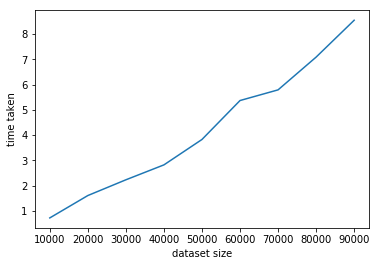

In [430]:
%matplotlib inline  
import matplotlib.pyplot as plt

x = [i * 10000 for i in range(1, 10)]
y = [measure_performance(i, 10) for i in x]
plt.ylabel('time taken')
plt.xlabel('dataset size')
plt.plot(x, y)

This linear relationship also holds with respect to the number of categories we decide to keep.

[+] Generating dataset...
[+] Transforming data...
Completed in (s): 0.7997057437896729
[+] Generating dataset...
[+] Transforming data...
Completed in (s): 1.0799179077148438
[+] Generating dataset...
[+] Transforming data...
Completed in (s): 1.0386936664581299
[+] Generating dataset...
[+] Transforming data...
Completed in (s): 1.3232142925262451
[+] Generating dataset...
[+] Transforming data...
Completed in (s): 1.3550572395324707
[+] Generating dataset...
[+] Transforming data...
Completed in (s): 1.637746810913086
[+] Generating dataset...
[+] Transforming data...
Completed in (s): 2.2435309886932373
[+] Generating dataset...
[+] Transforming data...
Completed in (s): 2.1309874057769775
[+] Generating dataset...
[+] Transforming data...
Completed in (s): 2.4376420974731445


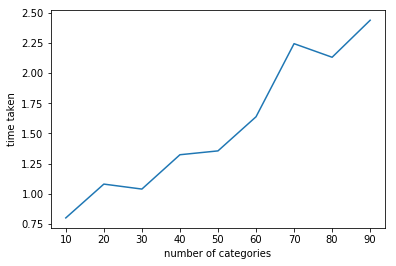

In [431]:
x = [i * 10 for i in range(1, 10)]
y = [measure_performance(10000, i) for i in x]
plt.ylabel('time taken')
plt.xlabel('number of categories')
plt.plot(x, y)

# Conclusion
While this encoder seems to demonstrate a reasonable performance for a few hundred thousand entries, the performance is not scalable to a million entries. This is mainly because considering 300 possible categories and 5 million possible tag entries (each entry can contain 5 tags), we have to generate 1.5 billion bits. While more low level programming may be able to improve this by some constant factor, I feel like the linear nature of the problem may impose a lower bound on the performance we can get. That being said, I think the maps and pranges help by a constant factor to vectorize some operations.